<a href="https://colab.research.google.com/github/AarifCha/Hamiltonian-Graph-Networks/blob/main/InteractionNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install -q tensorflow-gnn

from typing import Type, Callable, Optional, Mapping, Tuple
from google.protobuf import text_format
import tensorflow as tf
import tensorflow_gnn as tfgnn
import tensorflow_gnn.proto.graph_schema_pb2 as schema_pb2
from tensorflow_gnn.graph import graph_constants as const
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.8/836.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.5 MB/s et

# Graph Schema

In [ ]:
schema_pbtx = """
context {
  features {
    key: "time_step"
    value: {
      description: "dt used for updating the velocity and position"
      dtype: DT_FLOAT
    }
  }
}
node_sets {
  key: "particles"
  value {
    features {
      key: "position"
      value {
        description: "[x,y] position vector"
        dtype: DT_FLOAT
        shape { dim { size: 2 } }
      }
    }
    features {
      key: "velocity"
      value {
        description: "[v_x,v_y] velocity vector"
        dtype: DT_FLOAT
        shape { dim { size: 2 } }
      }
    }
  }
}
edge_sets {
  key: "interaction"
  value {
    source: "particles"
    target: "particles"
    features {
      key: "g"
      value {
        description: "interaction strength"
        dtype: DT_FLOAT
        shape { dim { size: 1 } }
      }
    }
  }
}
"""
graph_schema = text_format.Merge(schema_pbtx, schema_pb2.GraphSchema())
graph_tensor_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

list(graph_tensor_spec.node_sets_spec["particles"].features_spec.keys())

['position', 'velocity']

#### Schema part for mass
features {
      key: "mass"
      value {
        description: "mass of the particle"
        dtype: DT_FLOAT
        shape { dim { size: 1 } }
      }
    }

# Interaction Network Graph Update

## MLP builder.
returns a keras mlp layer made using keras.Sequential

In [ ]:
def build_mlp(num_hidden_layers: int,
              hidden_size: int,
              output_size: int,
              activation: str = "relu",
              activate_final: bool = False,
              name: str = "mlp"):
    output_sizes = [hidden_size] * num_hidden_layers + [output_size]
    mlp = tf.keras.Sequential(name = name)
    rate = 0.2
    for layer_i, size in enumerate(output_sizes):
        layer_activation = activation
        if not activate_final and layer_i == len(output_sizes) - 1:
            layer_activation = None
    #        rate = 0.0
        mlp.add(tf.keras.layers.Dense(
                size,
                activation = layer_activation,
                use_bias = True,
                kernel_initializer = "variance_scaling",
                kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                bias_regularizer=tf.keras.regularizers.L2(l2=0.001),
                bias_initializer = "zeros",
                name = f"{name}/dense_{layer_i}"))
     #   mlp.add(tf.keras.layers.Dropout(rate))
    return mlp

## Custom Convolve Class

In [ ]:
class AllNodeFeatruesConv(tf.keras.layers.Layer):
    def __init__(self, *,
                 message_fn: Type[tf.keras.layers.Layer],
                 reduction_type: str = "sum",
                 receiver_tag,
                 **kwargs):
        super().__init__(**kwargs)
        self._message_fn = message_fn
        self._reduction_type = reduction_type
        self._receiver_tag = receiver_tag

    def call(self, graph, edge_set_name):
        relative_states = []
        receiver_states = []
        sender_states = []
        for feature_name in list(graph.node_sets['particles'].features.keys()):
            if feature_name == 'position' or feature_name == 'velocity':
            #Use relative position and velocity instead.
                y = tfgnn.broadcast_node_to_edges(
                graph, edge_set_name, self._receiver_tag,
                feature_name = feature_name)

                x = tfgnn.broadcast_node_to_edges(
                graph, edge_set_name, tfgnn.reverse_tag(self._receiver_tag),
                feature_name = feature_name)
                relative_states = relative_states + [tf.math.subtract(y,x)]
            else:
              receiver_states = receiver_states + [tfgnn.broadcast_node_to_edges(
                  graph, edge_set_name, self._receiver_tag,
                  feature_name = feature_name)]
              sender_states = sender_states + [tfgnn.broadcast_node_to_edges(
                  graph, edge_set_name, tfgnn.reverse_tag(self._receiver_tag),
                  feature_name = feature_name)]

        message_inputs = (relative_states + receiver_states + sender_states
                          + [graph.edge_sets[edge_set_name].features["g"]])

        messages = self._message_fn(tf.concat(message_inputs, axis=-1))

        return tfgnn.pool_edges_to_node(graph, edge_set_name, self._receiver_tag,
                                        self._reduction_type, feature_value = messages)

## Custom Next Node State
If time permits, this will be changed to output the acceleration and some sort of integrator would be used to get the new position and velocity.

In [ ]:
class NextStateFromIntegration(tf.keras.layers.Layer):
    def __init__(self, transformation: Type[tf.keras.layers.Layer], **kwargs):
        super().__init__(**kwargs)
        self._transformation = transformation

    def call(self, inputs: Tuple[
          const.FieldOrFields, const.FieldsNest, const.FieldsNest
          ]) -> const.FieldOrFields:

        node, edge, context = inputs

        dt = context
        dt = tf.transpose([dt])

        concat_input = tf.concat(tf.nest.flatten((node, edge)), axis = -1)
        outputs = self._transformation(concat_input)

        dt = tf.broadcast_to(dt, tf.shape(outputs))

        vel = tf.add(node["velocity"], tf.multiply(dt, outputs))
        pos = tf.add(node["position"], tf.multiply(dt, vel))

        return {"position": pos, "velocity": vel}

## Interaction Network Graph Update

In [ ]:
def InteractionNetworkGraphUpdate(
    *,
    nodes_next_state_transformation: Type[tf.keras.layers.Layer],
    receiver_tag: Optional[tfgnn.IncidentNodeTag] = tfgnn.TARGET,
    reduce_type_to_nodes: str = "sum",
    name: str = "interaction_network") -> tfgnn.keras.layers.GraphUpdate:
    #nodes_next_state_transformation must output 2 elements (1 per dimension for acceleration)
    def deferred_init_callback(graph_spec):
        node_set_updates = {}

        EdgeConvlayer = build_mlp(num_hidden_layers = 3,
                                 hidden_size = 150,
                                 output_size = 30,
                                 activation = "tanh",
                                 activate_final = False,
                                 name = "EdgeConvLayer/mlp")

        next_state = NextStateFromIntegration(transformation = nodes_next_state_transformation)
        node_set_updates["particles"] = tfgnn.keras.layers.NodeSetUpdate(
            next_state = next_state,
            edge_set_inputs={
                "interaction": AllNodeFeatruesConv(
                                 message_fn = EdgeConvlayer,
                                 reduction_type = "sum",
                                 receiver_tag = tfgnn.TARGET)},
                node_input_feature = list(graph_spec.node_sets_spec["particles"].features_spec.keys()),
                context_input_feature = "time_step")
        return dict(edge_sets = None, node_sets = node_set_updates, context = None)

    return tfgnn.keras.layers.GraphUpdate(
        deferred_init_callback=deferred_init_callback, name=name)

## Interaction Network Layer

In [ ]:
class INLayer(tf.keras.layers.Layer):
    def __init__(self, name: str = "IN_Layer"):
        super().__init__(name = name)
        self.next_state_fn = build_mlp(num_hidden_layers = 2,
                                  hidden_size = 100,
                                  output_size = 2,
                                  activation = "tanh",
                                  activate_final = False,
                                  name = "Next_state_nodes_layer")
        self.Updater = InteractionNetworkGraphUpdate(
                                                nodes_next_state_transformation = self.next_state_fn,
                                                receiver_tag = tfgnn.TARGET,
                                                reduce_type_to_nodes = "sum",
                                                name = "Interaction_Network_GraphUpdate_Layer")
    def call(self, input_graph: tfgnn.GraphTensor) -> tfgnn.GraphTensor:
        return self.Updater(input_graph)

## Running tests with random graph with the graph_tensor_spec

In [ ]:
graph = tfgnn.random_graph_tensor(graph_tensor_spec)
#graph2 = tfgnn.random_graph_tensor(graph_tensor_spec)
graph

GraphTensor(
  context=Context(features={'time_step': <tf.Tensor: shape=(1,), dtype=tf.float32>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['particles'],
  edge_set_names=['interaction'])

In [ ]:
graph.node_sets["particles"].features

{'position': <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.35762548, 0.8104793 ],
       [0.66845083, 0.3272283 ],
       [0.8905437 , 0.707037  ],
       [0.89232945, 0.14851916]], dtype=float32)>, 'velocity': <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.13405418, 0.54334664],
       [0.07691109, 0.6057415 ],
       [0.8368883 , 0.9705782 ],
       [0.14411318, 0.6747111 ]], dtype=float32)>}

In [ ]:
Layer = INLayer()
new_graph = Layer(graph)
#new_graph2 = Layer(graph)

In [ ]:
new_graph.node_sets["particles"].features

{'position': <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.24128799, 0.32694566],
       [0.41119242, 0.64620143],
       [0.7974561 , 0.50199085],
       [0.17215078, 0.26541603]], dtype=float32)>, 'velocity': <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.08726458, 0.7589764 ],
       [0.8816756 , 0.10707043],
       [0.7977376 , 0.81092614],
       [0.22446188, 0.9332503 ]], dtype=float32)>}

In [ ]:
graph.edge_sets["interaction"].features

{'g': <tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[0.59599745],
       [0.2365216 ],
       [0.9620471 ],
       [0.38025784],
       [0.6822711 ],
       [0.7565428 ]], dtype=float32)>}

In [ ]:
new_graph.edge_sets["interaction"].features

{'g': <tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[0.59599745],
       [0.2365216 ],
       [0.9620471 ],
       [0.38025784],
       [0.6822711 ],
       [0.7565428 ]], dtype=float32)>}

# Simulation Data Generation

## Creating data by running a simulation

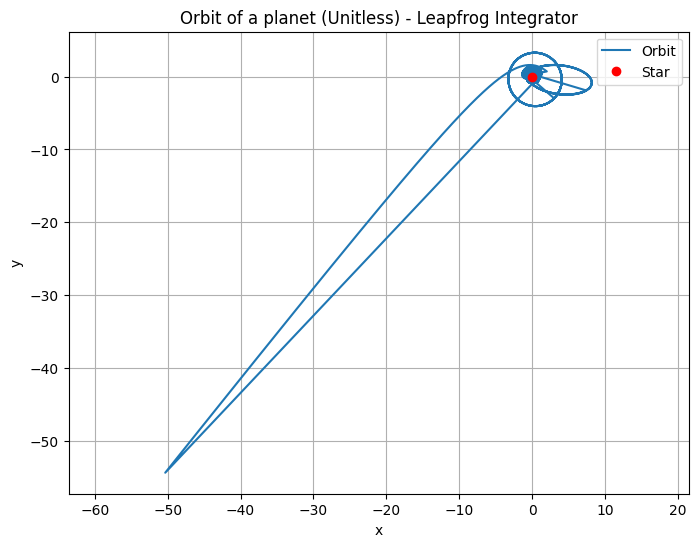

In [ ]:
#Integration Method
def get_acc(x,y):
  ms = 10
  r3 = np.sqrt(x**2 + y**2)**3
  ax, ay = -ms*x/r3, -ms*y/r3
  return ax, ay

def leapfrogIntStep(x,y,vx,vy,dt):

    ax, ay = get_acc(x,y)
    vxo, vyo = vx + dt*ax, vy + dt*ay
    xo, yo = x + dt*vxo, y + dt*vyo

  #  ax, ay = get_acc(x,y)  # Gravitational acceleration
  #  vxo = vx + 0.5 * ax * dt
  #  vyo = vy + 0.5 * ay * dt
  #  xo = x + vxo * dt
  #  yo = y + vyo * dt
  #  ax, ay = get_acc(xo,yo) # Updated acceleration using new position
  #  vxo += 0.5 * ax * dt
  #  vyo += 0.5 * ay * dt

    return xo, yo, vxo, vyo

def leapfrogInt(x_values, y_values, vx_values, vy_values, dt):
    for i in range(1, len(t_values)):
        x_values[i], y_values[i], vx_values[i], vy_values[i] = leapfrogIntStep(
            x_values[i-1], y_values[i-1], vx_values[i-1], vy_values[i-1], dt)

def gen_Orbit(x0,y0,vx0,vy0,t_values,dt):
    x_values = np.zeros_like(t_values)
    y_values = np.zeros_like(t_values)
    vx_values = np.zeros_like(t_values)
    vy_values = np.zeros_like(t_values)

    x_values[0] = x0
    y_values[0] = y0
    vx_values[0] = vx0
    vy_values[0] = vy0

    leapfrogInt(x_values, y_values, vx_values, vy_values, dt)
    return (x_values, y_values, vx_values, vy_values)

def random_in_out(num_outputs, dt):
    num_out_half = int(num_outputs/2)

    in_x_vals = np.concatenate((np.random.uniform(-5, -2, size=(num_out_half,)),
                              np.random.uniform(2, 5, size=(num_out_half,))))
    in_y_vals = np.concatenate((np.random.uniform(-5, -2, size=(num_out_half,)),
                              np.random.uniform(2, 5, size=(num_out_half,))))
    in_vx_vals = np.concatenate((np.random.uniform(-2, -0.5, size=(num_out_half,)),
                               np.random.uniform(0.5, 2, size=(num_out_half,))))
    in_vy_vals = np.concatenate((np.random.uniform(-2, -0.5, size=(num_out_half,)),
                               np.random.uniform(0.5, 2, size=(num_out_half,))))

    np.random.shuffle(in_x_vals)
    np.random.shuffle(in_y_vals)
    np.random.shuffle(in_vx_vals)
    np.random.shuffle(in_vy_vals)

    out_x_vals = np.zeros(num_outputs)
    out_y_vals = np.zeros(num_outputs)
    out_vx_vals = np.zeros(num_outputs)
    out_vy_vals = np.zeros(num_outputs)

    for i in range(num_outputs):
        (out_x_vals[i], out_y_vals[i], out_vx_vals[i], out_vy_vals[i]) = leapfrogIntStep(in_x_vals[i], in_y_vals[i], in_vx_vals[i], in_vy_vals[i],dt)

    input_data_array = [[x, y, vx, vy] for x, y, vx, vy in zip(in_x_vals, in_y_vals, in_vx_vals, in_vy_vals)]
    labels = [[x, y, vx, vy, dt] for x, y, vx, vy in zip(out_x_vals, out_y_vals, out_vx_vals, out_vy_vals)]

    return input_data_array, labels


# Initial conditions (unitless)
x0 = 1.0  # Initial x-position of the planet
y0 = 0.0  # Initial y-position of the planet
vx0 = 0.0  # Initial x-velocity of the planet
vy0 = 2.5  # Initial y-velocity of the planet
dt = 0.01  # Time step
tend = 60 # Final Time
t_values = np.arange(0, tend, dt)

# Time parameters
x1, y1, vx1, vy1 = gen_Orbit(x0,y0,vx0,vy0,t_values,dt)
x2, y2, vx2, vy2 = gen_Orbit(0.5,0.75,3,1,t_values,dt)
x3, y3, vx3, vy3 = gen_Orbit(2,0.7,-2.5,2,t_values,dt)
x4, y4, vx4, vy4 = gen_Orbit(0,-1,3,-3,t_values,dt)
x5, y5, vx5, vy5 = gen_Orbit(1,0,0,3,t_values,dt)
x6, y6, vx6, vy6 = gen_Orbit(3,-3,1,1,t_values,dt)

in1 = [[x, y, vx, vy] for x, y, vx, vy in zip(x1[:-1], y1[:-1], vx1[:-1], vy1[:-1])]
out1 = [[x, y, vx, vy, dt] for x, y, vx, vy in zip(x1[1:], y1[1:], vx1[1:], vy1[1:])]
in2 = [[x, y, vx, vy] for x, y, vx, vy in zip(x2[:-1], y2[:-1], vx2[:-1], vy2[:-1])]
out2 = [[x, y, vx, vy, dt] for x, y, vx, vy in zip(x2[1:], y2[1:], vx2[1:], vy2[1:])]
in3 = [[x, y, vx, vy] for x, y, vx, vy in zip(x3[:-1], y3[:-1], vx3[:-1], vy3[:-1])]
out3 = [[x, y, vx, vy, dt] for x, y, vx, vy in zip(x3[1:], y3[1:], vx3[1:], vy3[1:])]
in4 = [[x, y, vx, vy] for x, y, vx, vy in zip(x4[:-1], y4[:-1], vx4[:-1], vy4[:-1])]
out4 = [[x, y, vx, vy, dt] for x, y, vx, vy in zip(x4[1:], y4[1:], vx4[1:], vy4[1:])]

x_values = tf.concat([x1]+[x2]+[x3]+[x4]+[x5]+[x6], axis=-1).numpy()
y_values = tf.concat([y1]+[y2]+[y3]+[y4]+[y5]+[y6], axis=-1).numpy()
vx_values = tf.concat([vx1]+[vx2]+[vx3]+[vx4]+[vx5]+[vx6], axis=-1).numpy()
vy_values = tf.concat([vy1]+[vy2]+[vy3]+[vy4]+[vy5]+[vy6], axis=-1).numpy()

#x_values = x4
#y_values = y4
#vx_values = vx4
#vy_values = vy4

# Plot orbit
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Orbit')
plt.plot(0, 0, 'ro', label='Star')  # Star at the origin
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of a planet (Unitless) - Leapfrog Integrator')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

## Convert Data to tf.data.Dataset of GraphTensors

In [ ]:
#input_data_array1 = [[x, y, vx, vy] for x, y, vx, vy in zip(x_values[:-1], y_values[:-1], vx_values[:-1], vy_values[:-1])]
#output_data_array1 = [[x, y, vx, vy,dt] for x, y, vx, vy in zip(x_values[1:], y_values[1:], vx_values[1:], vy_values[1:])]

input_data_array2, output_data_array2 = random_in_out(1000,0.01)

#input_data1 = tf.convert_to_tensor(input_data_array1)
#labels1 = tf.convert_to_tensor(output_data_array1)

input_data1 = tf.concat([in1] + [in2] + [in3] + [in4], axis=0)
labels1 = tf.concat([out1] + [out2] + [out3] + [out4], axis=0)

input_data2 = tf.convert_to_tensor(input_data_array2)
labels2 = tf.convert_to_tensor(output_data_array2)

input_data = tf.concat([input_data1, input_data2], axis=0)
labels = tf.concat([labels1, labels2], axis=0)

graph_info = tf.concat([input_data, labels],axis=-1)

dataset = tf.data.Dataset.from_tensor_slices(graph_info)

def convert_to_graph(graph_info, verbose = False):
    # Sun is particle 0 centered at (0,0) and no velocity
    # The planet is particle 1
    if verbose:
      print(graph_info)
    in_pos = tf.cast(tf.convert_to_tensor([graph_info[0], graph_info[1]]), tf.float32)
    in_vel = tf.cast(tf.convert_to_tensor([graph_info[2], graph_info[3]]), tf.float32)
    dt = tf.cast(tf.convert_to_tensor([graph_info[8]]), tf.float32)

    label = [[0,0,0,0], graph_info[4:8]]

    graph = tfgnn.GraphTensor.from_pieces(
        node_sets={
            "particles": tfgnn.NodeSet.from_fields(
                sizes = [2],
                features = {
                    "position": [tf.constant([0.0,0.0]), in_pos],
                    "velocity": [tf.constant([0.0,0.0]), in_vel]})},
        edge_sets={
            "interaction": tfgnn.EdgeSet.from_fields(
                sizes = [1],
                features = {"g": tf.expand_dims(tf.cast(tf.constant([1.0]),tf.float32), axis=0)},
                adjacency = tfgnn.Adjacency.from_indices(
                    source = ("particles", [0]),
                    target = ("particles", [1])))},
        context=tfgnn.Context.from_fields(
                features = {"time_step": dt}))

    return graph, label

dataset = dataset.map(convert_to_graph).shuffle(buffer_size=50000).batch(32)

#### Check outputs

In [ ]:
g, y = dataset.take(1).get_single_element()

In [ ]:
g.merge_batch_to_components().context

Context(features={'time_step': <tf.Tensor: shape=(32,), dtype=tf.float32>}, sizes=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(), indices_dtype=tf.int32)

In [ ]:
new_graph = model(g.merge_batch_to_components())

# Training

## Model

In [ ]:
tf.keras.backend.clear_session()

Model_layer = INLayer()

optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=46000,
        decay_rate=0.30),
    )

input_graph = tf.keras.layers.Input(type_spec=graph_tensor_spec)
graph = input_graph.merge_batch_to_components()

output_graph = Model_layer(graph)
output = tf.concat([output_graph.node_sets["particles"].features["position"]]
                   + [output_graph.node_sets["particles"].features["velocity"]],axis=-1)

model = tf.keras.Model(inputs = input_graph, outputs = output, name="IN_Model")

model.summary()

Model: "IN_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [()]                         0         []                            
                                                                                                  
 input.merge_batch_to_compo  ()                           0         ['input_1[0][0]']             
 nents (InstanceMethod)                                                                           
                                                                                                  
 IN_Layer (INLayer)          ()                           64532     ['input.merge_batch_to_compone
                                                                    nts[0][0]']                   
                                                                                           

## Custom Loss and Training

In [ ]:
@tf.function
def custom_loss(y_true, y_pred):
    y_true_reshaped = tf.reshape(y_true,(-1,4))
    sum_squared_diff = tf.reduce_sum(tf.square(y_true_reshaped - y_pred))
    return (sum_squared_diff)

class PrintEvery10thEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}: Loss = {logs['loss']}")

model.compile(optimizer=optimizer, loss=custom_loss)
#history = model.fit(dataset, epochs=10, callbacks=[PrintEvery10thEpoch()], verbose=0)
history = model.fit(dataset, epochs=75)

Epoch 1/75
782/782 [==============================] - 8s 5ms/step - loss: 2.5343
Epoch 2/75
782/782 [==============================] - 5s 4ms/step - loss: 1.8506
Epoch 3/75
782/782 [==============================] - 5s 5ms/step - loss: 1.6187
Epoch 4/75
782/782 [==============================] - 7s 5ms/step - loss: 1.4573
Epoch 5/75
782/782 [==============================] - 4s 4ms/step - loss: 1.3612
Epoch 6/75
782/782 [==============================] - 6s 6ms/step - loss: 1.2924
Epoch 7/75
782/782 [==============================] - 4s 4ms/step - loss: 1.2453
Epoch 8/75
782/782 [==============================] - 6s 6ms/step - loss: 1.2182
Epoch 9/75
782/782 [==============================] - 5s 4ms/step - loss: 1.1956
Epoch 10/75
782/782 [==============================] - 6s 6ms/step - loss: 1.1880
Epoch 11/75
782/782 [==============================] - 4s 4ms/step - loss: 1.1710
Epoch 12/75
782/782 [==============================] - 5s 4ms/step - loss: 1.1532
Epoch 13/75
782/782 [====

In [ ]:
print(model.predict(g)[0,:])
print(tf.reshape(y,(-1,4))[0,:])

1/1 [==============================] - 1s 720ms/step
[ 4.349896e-05 -8.649687e-05  4.349896e-03 -8.649687e-03]
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float64)


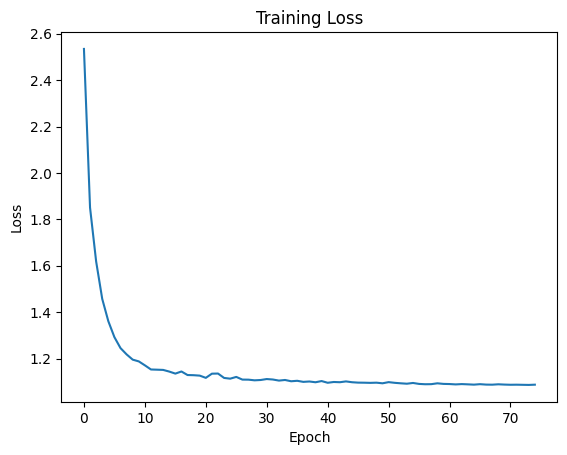

1.0876822471618652


In [ ]:
loss = history.history['loss']
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print(loss[-1])

# Predicting the Continuation of the Orbit

In [ ]:
def get_new_pos_and_vel_graph(graph):
  next_graph = Model_layer(graph)
  return (next_graph.node_sets["particles"].features["position"],
          next_graph.node_sets["particles"].features["velocity"],
          next_graph)

In [ ]:
def get_new_pos_and_vel(pos_vel_vec,dt):
    graph_info = [tf.squeeze(tf.concat([pos_vel_vec, [0,0,0,0,dt]],axis=-1))]

    last_data = tf.data.Dataset.from_tensor_slices(graph_info)

    last_data = last_data.map(convert_to_graph).batch(1)

    for input, label in last_data:
        input_graph = input

    return model.predict(input_graph, verbose=0)

In [ ]:
def get_start_graph(pos_vel_vec,dt):
  graph_info = tf.squeeze(tf.concat([pos_vel_vec, [0,0,0,0,dt]],axis=-1))
  return convert_to_graph(graph_info, False)[0]

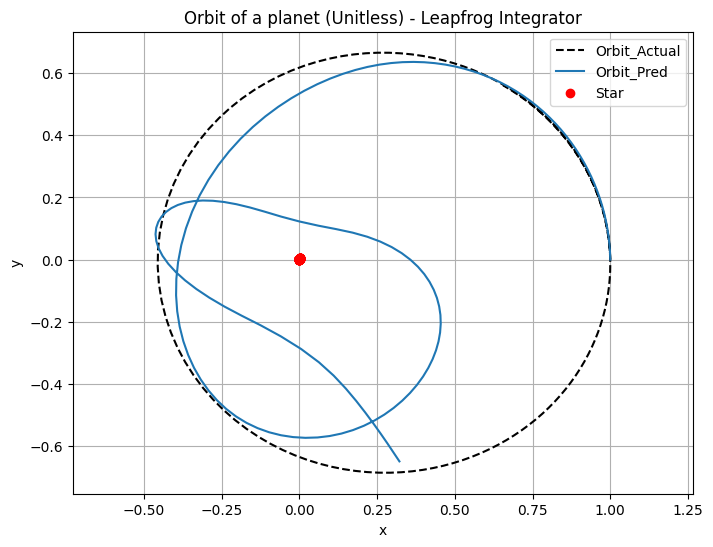

In [ ]:
num_pred = 150
pos_pred = np.zeros((num_pred,2),dtype=np.float32)
vel_pred = np.zeros((num_pred,2),dtype=np.float32)

pos_pred_sun = np.zeros((num_pred,2),dtype=np.float32)
vel_pred_sun = np.zeros((num_pred,2),dtype=np.float32)

#input_data_array = [[x, y, vx, vy] for x, y, vx, vy in zip(x_values[-2:-1], y_values[-2:-1], vx_values[-2:-1], vy_values[-2:-1])]
input_data_array = [[x, y, vx, vy] for x, y, vx, vy in zip(x_values[0:1], y_values[0:1], vx_values[0:1], vy_values[0:1])]
input_data = tf.cast(tf.squeeze(tf.convert_to_tensor(input_data_array)),dtype=tf.float32)


pos_pred[0] = [input_data[0], input_data[1]]
vel_pred[0] = [input_data[2], input_data[3]]

# pos_pred_sun[0] = [0, 0]
# vel_pred_sun[0] = [0, 0]

pos_vel_vec = tf.squeeze(tf.concat([pos_pred[0], vel_pred[0]],axis=-1))
graph = get_start_graph(pos_vel_vec,dt)

for i in range(1,num_pred):
    # temp = get_new_pos_and_vel(tf.squeeze(tf.concat([pos_pred[i-1], vel_pred[i-1]],axis=-1)),0.01)
    # pos_pred[i] = [temp[1,0], temp[1,1]]
    # vel_pred[i] = [temp[1,2], temp[1,3]]
    temp_x, temp_v, graph = get_new_pos_and_vel_graph(graph)
    pos_pred[i] = [temp_x[1,0], temp_x[1,1]]
    vel_pred[i] = [temp_v[1,0], temp_v[1,1]]

    pos_pred_sun[i] = [temp_x[0,0], temp_x[0,1]]
    vel_pred_sun[i] = [temp_v[0,0], temp_v[0,1]]


plt.figure(figsize=(8, 6))
plt.plot(x_values[0:150], y_values[0:150], '--k', label='Orbit_Actual')
plt.plot(pos_pred[:,0], pos_pred[:,1],label='Orbit_Pred')
plt.plot(pos_pred_sun[:,0], pos_pred_sun[:,1], 'ro', label='Star')  # Star at the origin
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of a planet (Unitless) - Leapfrog Integrator')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

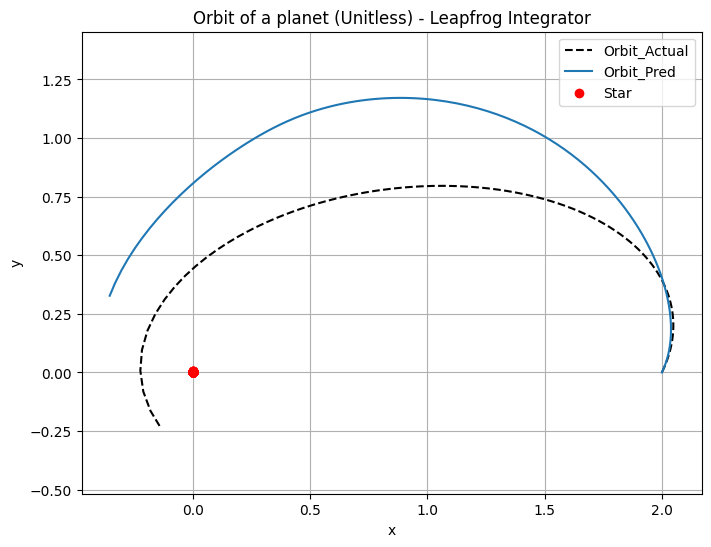

In [ ]:
num_pred = 150
pos_pred = np.zeros((num_pred,2),dtype=np.float32)
vel_pred = np.zeros((num_pred,2),dtype=np.float32)

pos_pred_sun = np.zeros((num_pred,2),dtype=np.float32)
vel_pred_sun = np.zeros((num_pred,2),dtype=np.float32)

#input_data_array = [[x, y, vx, vy] for x, y, vx, vy in zip(x_values[-2:-1], y_values[-2:-1], vx_values[-2:-1], vy_values[-2:-1])]
input_data_array = [2, 0, 0.5, 1]
input_data = tf.cast(tf.squeeze(tf.convert_to_tensor(input_data_array)),dtype=tf.float32)

x_val, y_val, _, _ = gen_Orbit(2, 0, 0.5, 1, t_values, 0.01)


pos_pred[0] = [input_data[0], input_data[1]]
vel_pred[0] = [input_data[2], input_data[3]]

pos_vel_vec = tf.squeeze(tf.concat([pos_pred[0], vel_pred[0]],axis=-1))
graph = get_start_graph(pos_vel_vec,dt)

for i in range(1,num_pred):
    # temp = get_new_pos_and_vel(tf.squeeze(tf.concat([pos_pred[i-1], vel_pred[i-1]],axis=-1)),0.01)
    # pos_pred[i] = [temp[1,0], temp[1,1]]
    # vel_pred[i] = [temp[1,2], temp[1,3]]
    temp_x, temp_v, graph = get_new_pos_and_vel_graph(graph)
    pos_pred[i] = [temp_x[1,0], temp_x[1,1]]
    vel_pred[i] = [temp_v[1,0], temp_v[1,1]]

    pos_pred_sun[i] = [temp_x[0,0], temp_x[0,1]]
    vel_pred_sun[i] = [temp_v[0,0], temp_v[0,1]]

plt.figure(figsize=(8, 6))
plt.plot(x_val[:150], y_val[:150], '--k', label='Orbit_Actual')
plt.plot(pos_pred[:,0], pos_pred[:,1],label='Orbit_Pred')
plt.plot(pos_pred_sun[:,0], pos_pred_sun[:,1], 'ro', label='Star')  # Star at the origin
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of a planet (Unitless) - Leapfrog Integrator')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()